In [ ]:
import os
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

# Here you can read about [DANN](https://jmlr.org/papers/volume17/15-239/15-239.pdf)

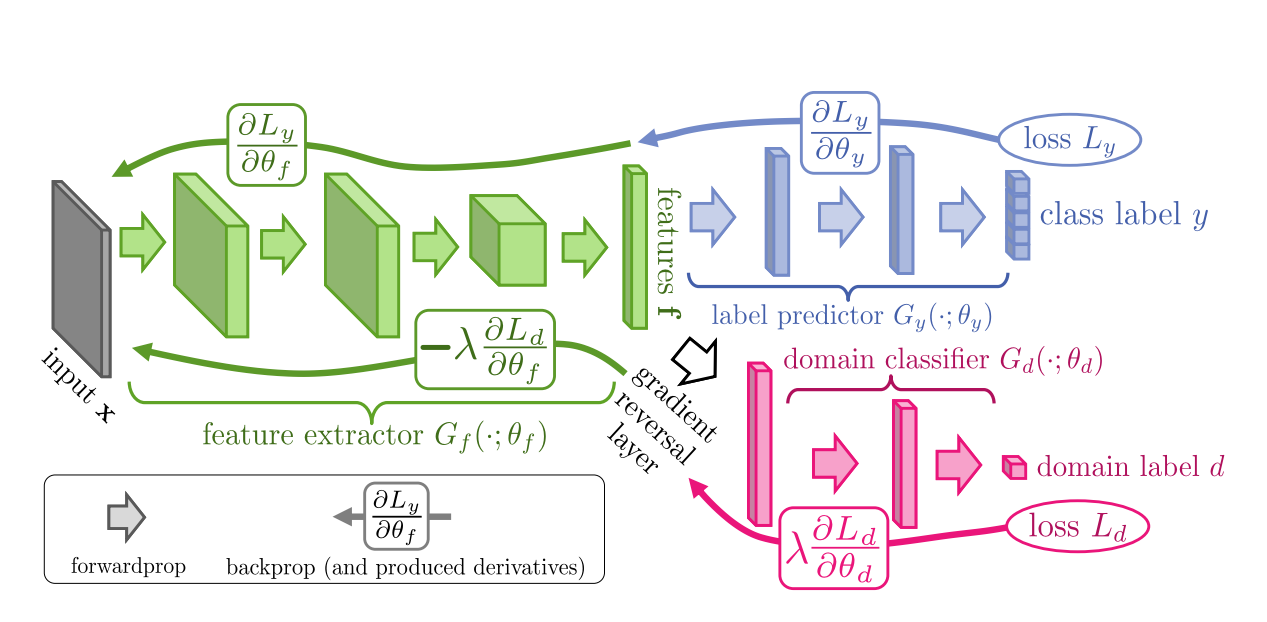

Below you will find a simplified version of a domain adaptation model for tabular data. The implementation includes an extractor for feature extraction, a classifier for label prediction, and a discriminator with a gradient reversal layer to facilitate domain-invariant feature learning.

In [ ]:
INITAL_LR = ...
FINAL_LR = ...

EPOCHS = ...

In [ ]:
class Extractor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Extractor, self).__init__()
        
        self.extractor = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=64),
            nn.Dropout(p=.5),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=64, out_features=output_size),
            nn.Dropout(p=.5),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.extractor(x)

In [ ]:
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=16),
            nn.Dropout(),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=16, out_features=num_classes),
        )
        
    def forward(self, x):
        return self.classifier(x)

In [ ]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, _lambda):
        ctx.lambda_ = _lambda
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx._lambda, None


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=16),
            nn.LeakyReLU(),
            
            nn.Linear(in_features=16, out_features=2)
        )
        
    def forward(self, x, alpha):
        x = GradientReversalFunction.apply(x, alpha)
        return self.discriminator(x)

In [ ]:
from sklearn.metrics import balanced_accuracy_score, classification_report

class DANN:
    def __init__(self, input_size, output_size, num_classes):
        """
        Initialize the DANN model components.
        
        Parameters:
            input_size (int): Size of the input features.
            output_size (int): Size of the features after extraction.
            num_classes (int): Number of target classes for classification.
        """
        self.extractor = Extractor(input_size, output_size)
        self.classifier = Classifier(output_size, num_classes)
        self.discriminator = Discriminator(output_size)
    
    def train_dann(self,
                   source_train_loader: torch.utils.data.DataLoader,
                   target_train_loader: torch.utils.data.DataLoader,
                   source_val_loader: torch.utils.data.DataLoader,
                   target_val_loader: torch.utils.data.DataLoader,
                   device: torch.device,
                   epochs: int,
                   init_lr: float,
                   final_lr: float
        ) -> None:
        """
        Train the DANN model using domain adaptation.
        
        This method trains both the classification branch on the source domain
        and the adversarial domain discriminator on both source and target domains.
        It adjusts the learning rate via an exponential scheduler and prints training metrics.
        
        Parameters:
            source_train_loader (DataLoader): DataLoader for the source training dataset.
            target_train_loader (DataLoader): DataLoader for the target training dataset.
            source_val_loader (DataLoader): DataLoader for the source validation dataset.
            target_val_loader (DataLoader): DataLoader for the target validation dataset.
            device (torch.device): Device on which computations will run.
            epochs (int): Number of training epochs.
            init_lr (float): Initial learning rate for the optimizer.
            final_lr (float): Final learning rate for the optimizer.
        """
        print("Training with the DANN adaptation method")

        self.extractor.train().to(device)
        self.classifier.train().to(device)
        self.discriminator.train().to(device)
        
        classifier_criterion = nn.CrossEntropyLoss()
        discriminator_criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(
            list(self.extractor.parameters()) +
            list(self.classifier.parameters()) +
            list(self.discriminator.parameters()),
            lr=init_lr,
            amsgrad=True)
        
        gamma = (final_lr / init_lr) ** (1 / epochs) * 0.995
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        
        for epoch in tqdm(range(epochs), desc='Epoch'):         
            epoch_class_loss = 0.0
            epoch_domain_loss = 0.0
            epoch_total_loss = 0.0

            start_steps = epoch * len(source_train_loader)
            total_steps = epochs * len(target_train_loader)

            for batch_idx, (source_data, target_data) in enumerate(tqdm(zip(source_train_loader, target_train_loader), desc="Batch", total=len(source_train_loader))):
                p = float(batch_idx + start_steps) / total_steps
                alpha = 2. / (1. + torch.exp(-10 * p)) - 1
                
                source_features, source_labels = source_data[0].to(device), source_data[1].to(device)
                target_features, target_labels = target_data[0].to(device), target_data[1].to(device)
                
                optimizer.zero_grad()

                # 1. Classification loss
                source_feature_output = self.extractor(source_features)
                
                class_pred = self.classifier(source_feature_output)
                class_loss = classifier_criterion(class_pred, source_labels)

                # 2. Domain loss
                domain_source_labels = torch.zeros(source_labels.shape[0]).type(torch.LongTensor)
                domain_target_labels = torch.ones(target_labels.shape[0]).type(torch.LongTensor)
                domain_combined_labels = torch.cat((domain_source_labels, domain_target_labels), 0)
                
                combined_features = torch.cat((source_features, target_features), 0)
                combined_feature_output = self.extractor(combined_features)
                domain_pred = self.discriminator(combined_feature_output, alpha)
                
                domain_loss = discriminator_criterion(domain_pred, domain_combined_labels)

                # 3. Total loss
                total_loss = class_loss + domain_loss
                total_loss.backward()
                optimizer.step()
                
                epoch_class_loss += class_loss.item()
                epoch_domain_loss += domain_loss.item()
                epoch_total_loss += total_loss.item()
                
            scheduler.step()
            print(f'Epoch {epoch + 1} Total Loss: {epoch_total_loss:.4f} Classification Loss: {epoch_class_loss:.4f} Domain Loss: {epoch_domain_loss:.4f}')
            self.test(source_val_loader, target_val_loader, device)
        
        self.save_models()
            
            
    def test(self,
             source_test_loader: torch.utils.data.DataLoader,
             target_test_loader: torch.utils.data.DataLoader,
             device: torch.device
        ) -> tuple[list, list, list, list]:
        """
        Evaluate the DANN model on source and target test datasets.
        
        This method computes classification predictions on both domains and
        evaluates the domain discriminator's performance.
        
        Parameters:
            source_test_loader (DataLoader): DataLoader for the source test dataset.
            target_test_loader (DataLoader): DataLoader for the target test dataset.
            device (torch.device): Device on which computations will be performed.
        
        Returns:
            tuple: A tuple containing source labels, source predictions, target labels,
                   and target predictions.
        """
        self.discriminator.eval().to(device)
        self.classifier.eval().to(device)
        self.extractor.eval().to(device)
                        
        all_source_labels = []
        all_source_preds = []
        all_target_labels = []
        all_target_preds = []
        all_domain_labels = []
        all_domain_preds = []

        with torch.no_grad():
            for source_data in source_test_loader:
                source_features, source_labels = source_data[0].to(device), source_data[1].to(device)
                
                source_feature_output = self.extractor(source_features)
                class_pred = self.classifier(source_feature_output)
                class_pred_labels = torch.argmax(class_pred, dim=1)

                all_source_labels.extend(source_labels.numpy())
                all_source_preds.extend(class_pred_labels.numpy())

                domain_pred = self.discriminator(source_feature_output, alpha=1.0)
                domain_pred_labels = torch.argmax(domain_pred, dim=1)
                
                all_domain_labels.extend(torch.zeros(source_labels.shape[0]).numpy())
                all_domain_preds.extend(domain_pred_labels.numpy())

            for target_data in target_test_loader:
                target_features, target_labels = target_data[0].to(device), target_data[1].to(device)

                target_feature_output = self.extractor(target_features)
                class_pred = self.classifier(target_feature_output)
                class_pred_labels = torch.argmax(class_pred, dim=1)

                all_target_labels.extend(target_labels.numpy())
                all_target_preds.extend(class_pred_labels.numpy())

                domain_pred = self.discriminator(target_feature_output, alpha=1.0)
                domain_pred_labels = torch.argmax(domain_pred, dim=1)
                
                all_domain_labels.extend(torch.ones(target_labels.shape[0]).numpy())
                all_domain_preds.extend(domain_pred_labels.numpy())

        # Calculate metrics
        balanced_acc = balanced_accuracy_score(all_domain_labels, all_domain_preds)
        source_class_report = classification_report(all_source_labels, all_source_preds)
        target_class_report = classification_report(all_target_labels, all_target_preds)

        print(f"Balanced Accuracy for Domain Discriminator: {balanced_acc:.4f}")
        print("Classification Report for Source Test Set:\n", source_class_report)
        print("Classification Report for Target Test Set:\n", target_class_report)
        
        return all_source_labels, all_source_preds, all_target_labels, all_target_preds
        
        
    def save_models(self):
        """
        Save the state dictionaries of the extractor, classifier, and discriminator models.
        
        The models are saved to a directory named 'models'.
        """
        model_dir = os.path.join('models')
        os.makedirs(model_dir, exist_ok=True)
        torch.save(self.extractor.state_dict(), os.path.join(model_dir, 'extractor.pth'))
        torch.save(self.classifier.state_dict(), os.path.join(model_dir, 'classifier.pth'))
        torch.save(self.discriminator.state_dict(), os.path.join(model_dir, 'discriminator.pth'))
        print(f'Models saved to {model_dir}')


    def load_models(self):
        """
        Load the state dictionaries for the extractor, classifier, and discriminator models
        from the 'models' directory.
        """
        model_dir = os.path.join('models')
        self.extractor.load_state_dict(torch.load(os.path.join(model_dir, 'extractor.pth')))
        self.classifier.load_state_dict(torch.load(os.path.join(model_dir, 'classifier.pth')))
        self.discriminator.load_state_dict(torch.load(os.path.join(model_dir, 'discriminator.pth')))
        print(f'Models loaded from {model_dir}')